In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from astropy.table import Table
import pickle
import pandas as pd
import SyntheticData as sd
import Sampler
import json

/home/bepennell/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [6]:
import style

In [2]:
mdwarfs = Table.read('./data/200pc_mdwarfs_reduced.fits', format='fits')
all_mdwarfs = []
relevant_list = ["parallax", "mass", "solution_type"]
for row in tqdm(mdwarfs): # we don't need every object, really 
    df = dict()
    for item in relevant_list:
        working_item = item
        if item == "mass":
            working_item = "mass_single"
        df[item] = float(row[working_item])
    all_mdwarfs.append(df)
    
percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])-5
masses = np.array([t["mass"] for t in all_mdwarfs])
mass_lims = np.percentile(masses, percentiles) 

  0%|          | 0/255556 [00:00<?, ?it/s]

## Compute Binarities

In [14]:
REF_FRACTIONS = (0.25, 0.5)
MASS_RANGE = (0.2, 0.4)
def bin_frac(m):
    sep = (m - MASS_RANGE[0]) / (MASS_RANGE[1] - MASS_RANGE[0])
    return sep * (REF_FRACTIONS[1] - REF_FRACTIONS[0]) + REF_FRACTIONS[0]

In [22]:
data_test = sd.create_synthetic_data(object_count=100000, catalogue=mdwarfs[::2], binarity_model=bin_frac, period_model=(5,2), mass_model=None, ecc_type='circular')

Computing Binaries:   0%|          | 0/40181 [00:00<?, ?it/s]

In [39]:
outdata = dict()
outdata["meta"] = dict()
outdata["meta"]["metaparams"] = f"{0.3} Binary fraction, {0} q index, P(T): (5,2)"
outdata["meta"]["notes"] = "2026.01.12 100k samples, circular only. linear binary fraction increase"
outdata["data"] = dict()
outdata["data"] = data_test

outfile = open('./massive_data/variablebinarity.pkl', "wb")
pickle.dump(outdata, outfile)
outfile.close()

In [11]:
data_test = pickle.load(open("./massive_data/variablebinarity.pkl", "rb"))["data"]

In [12]:
counters = np.zeros(len(mass_lims))
orb_counters = np.zeros(len(mass_lims))
highr_counters = np.zeros(len(mass_lims))
lens = np.zeros(len(mass_lims))
for mass_index in tqdm(range(len(mass_lims))):
    counter = 0
    orb_counter = 0
    highr_counter = 0
    temp_catalogue = []
    for _, obj in enumerate(data_test):
        if mass_index == 0:
            if obj["mass"] < mass_lims[0]:
                temp_catalogue.append(obj)
                if obj["is_binary"]:
                    counter += 1
                    if obj["solution_type"] > 0:
                        highr_counter += 1
                    if obj["solution_type"] > 5:
                        orb_counter += 1
        else:
            if (mass_lims[mass_index-1] < obj["mass"]) & (obj["mass"] < mass_lims[mass_index]):
                temp_catalogue.append(obj)
                if obj["is_binary"]:
                    counter += 1
                    if obj["solution_type"] > 0:
                        highr_counter += 1
                    if obj["solution_type"] > 5:
                        orb_counter += 1
        
    print(f'{counter/len(temp_catalogue)*100:.2f}, {highr_counter/len(temp_catalogue)*100:.2f}, {orb_counter/len(temp_catalogue)*100:.2f}')

    counters[mass_index] = counter
    orb_counters[mass_index] = orb_counter
    highr_counters[mass_index] = highr_counter
    lens[mass_index] = len(temp_catalogue)
refrates = counters/lens
#plt.plot(mass_lims, orb_counters/highr_counters, color="forestgreen");

  0%|          | 0/10 [00:00<?, ?it/s]

25.82, 1.73, 0.24
31.42, 2.16, 0.34
34.30, 2.53, 0.43
36.27, 3.02, 0.54
39.13, 2.90, 0.56
41.02, 3.66, 0.83
42.72, 4.03, 0.93
45.06, 4.23, 1.06
46.54, 4.99, 1.36
47.94, 5.62, 1.78


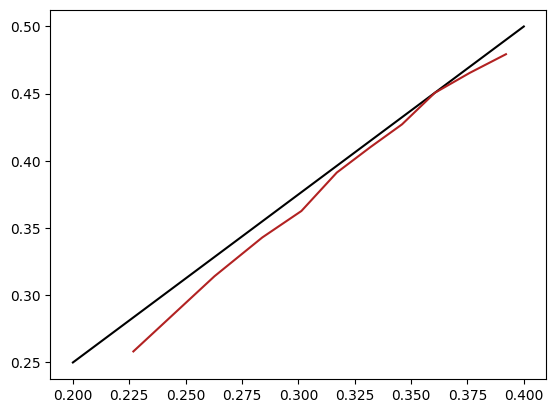

In [15]:
ms = np.linspace(0.2, 0.4, 100)
plt.plot(ms, bin_frac(ms), color="k");
plt.plot(mass_lims, refrates, color="firebrick");

In [27]:
percentiles = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])-5
masses = np.array([t["mass"] for t in all_mdwarfs])
mass_lims = np.percentile(masses, percentiles)

def convert_to_usable(sc_cubes, mass_index):
    target_mass = sc_cubes["meta"]["reference_masses"][mass_index]
    
    out_sc_cube = {}
    out_sc_cube["data"] = sc_cubes["data"][target_mass]
    out_sc_cube["meta"] = {}
    out_sc_cube["meta"]["shape"] = sc_cubes["meta"]["shape"]
    out_sc_cube["meta"]["lambdas"] = np.array(sc_cubes["meta"]["lambdas"][mass_index])
    out_sc_cube["meta"]["periods"] = sc_cubes["meta"]["periods"]
    out_sc_cube["meta"]["parallaxes"] = sc_cubes["meta"]["parallaxes"]
    
    out_catalogue = []
    for i in range(3):
        out_catalogue = out_catalogue + sc_cubes["meta"]["memory_reduced_catalogue"][mass_index][i]

    # pull out only what we need
    memory_reduced = []
    relevant_list = ["parallax", "mass", "solution_type", "phot_g_mean_mag"]
    for row in out_catalogue: 
        df = dict()
        for item in relevant_list:
            working_item = item
            if item == "mass":
                working_item = "mass_single"
            df[item] = float(row[working_item])
        memory_reduced.append(df)
    
    return out_sc_cube, memory_reduced

def mass_binned_data(sc_cubes, catalogue, mass_binned=False, p_model=(4,2), q_model=0, model_cube_size=(15,15), scale=5):
    synth_results = []

    for mass_index in tqdm(range(len(mass_lims))):
        temp_catalogue = []
        for _, obj in enumerate(catalogue):
            if mass_index == 0:
                if obj["mass"] < mass_lims[0]:
                    temp_catalogue.append(obj)
            else:
                if (mass_lims[mass_index-1] < obj["mass"]) & (obj["mass"] < mass_lims[mass_index]):
                    temp_catalogue.append(obj)
        
        # reduce to only mandatory objects to save on memory
        working_catalogue = []
        relevant_list = ["parallax", "mass", "solution_type"]
        for row in temp_catalogue:
            df = dict()
            df["mass_index"] = mass_index
            for item in relevant_list:
                df[item] = float(row[item])
            working_catalogue.append(df)
        
        model_cube = Sampler.create_model_cube(model_cube_size, p_model=p_model, q_model=q_model)
        out_sc_cube = sc_cubes
        if mass_binned:
            out_sc_cube, _ = convert_to_usable(sc_cubes, mass_index)
        synthsampler = Sampler.popsampler(out_sc_cube, working_catalogue, model_cube=model_cube)
        _, _ = synthsampler.binarity(resolution=1000, scale=scale, verbose=False)
        synth_results.append(synthsampler.fb_estimator())
        print(synthsampler.fb_estimator()[0])
    synth_results = np.array(synth_results)
    return synth_results

def generate_plot(synth_results, target_fb=None):
    plt.errorbar(mass_lims, synth_results[:,0], yerr=(synth_results[:,2], synth_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
    plt.scatter(mass_lims, synth_results[:,0], marker='o', zorder=2);
    if target_fb is not None:
        plt.axhline(y=target_fb, c="green", linestyle="--");

In [28]:
sc_cubes_circular = pickle.load(open("./data/2025-12-19-mdwarf_mbins_3plx_circular.pkl", "rb"))

In [30]:
synth_results = mass_binned_data(sc_cubes_circular, data_test, mass_binned=True, p_model=(5,2), q_model=0, model_cube_size=(25,10), scale=2)

  0%|          | 0/10 [00:00<?, ?it/s]

0.266006006006006
0.3275075075075075
0.37075075075075076
0.4159159159159159
0.3726726726726727
0.42072072072072075
0.42744744744744745
0.4120720720720721
0.4524324324324324
0.463963963963964


In [16]:
outdata = dict()
outdata["meta"] = dict()
outdata["notes"] = "2026.01.12 linear binary fraction increase"
outdata["data"] = dict()
outdata["data"] = synth_results, refrates

outfile = open('./plot_data/variablebinarity_test.pkl', "wb")
pickle.dump(outdata, outfile)
outfile.close()

## Make Plot

In [3]:
synth_results, refrates = pickle.load(open("./plot_data/variablebinarity_test.pkl", "rb"))["data"]

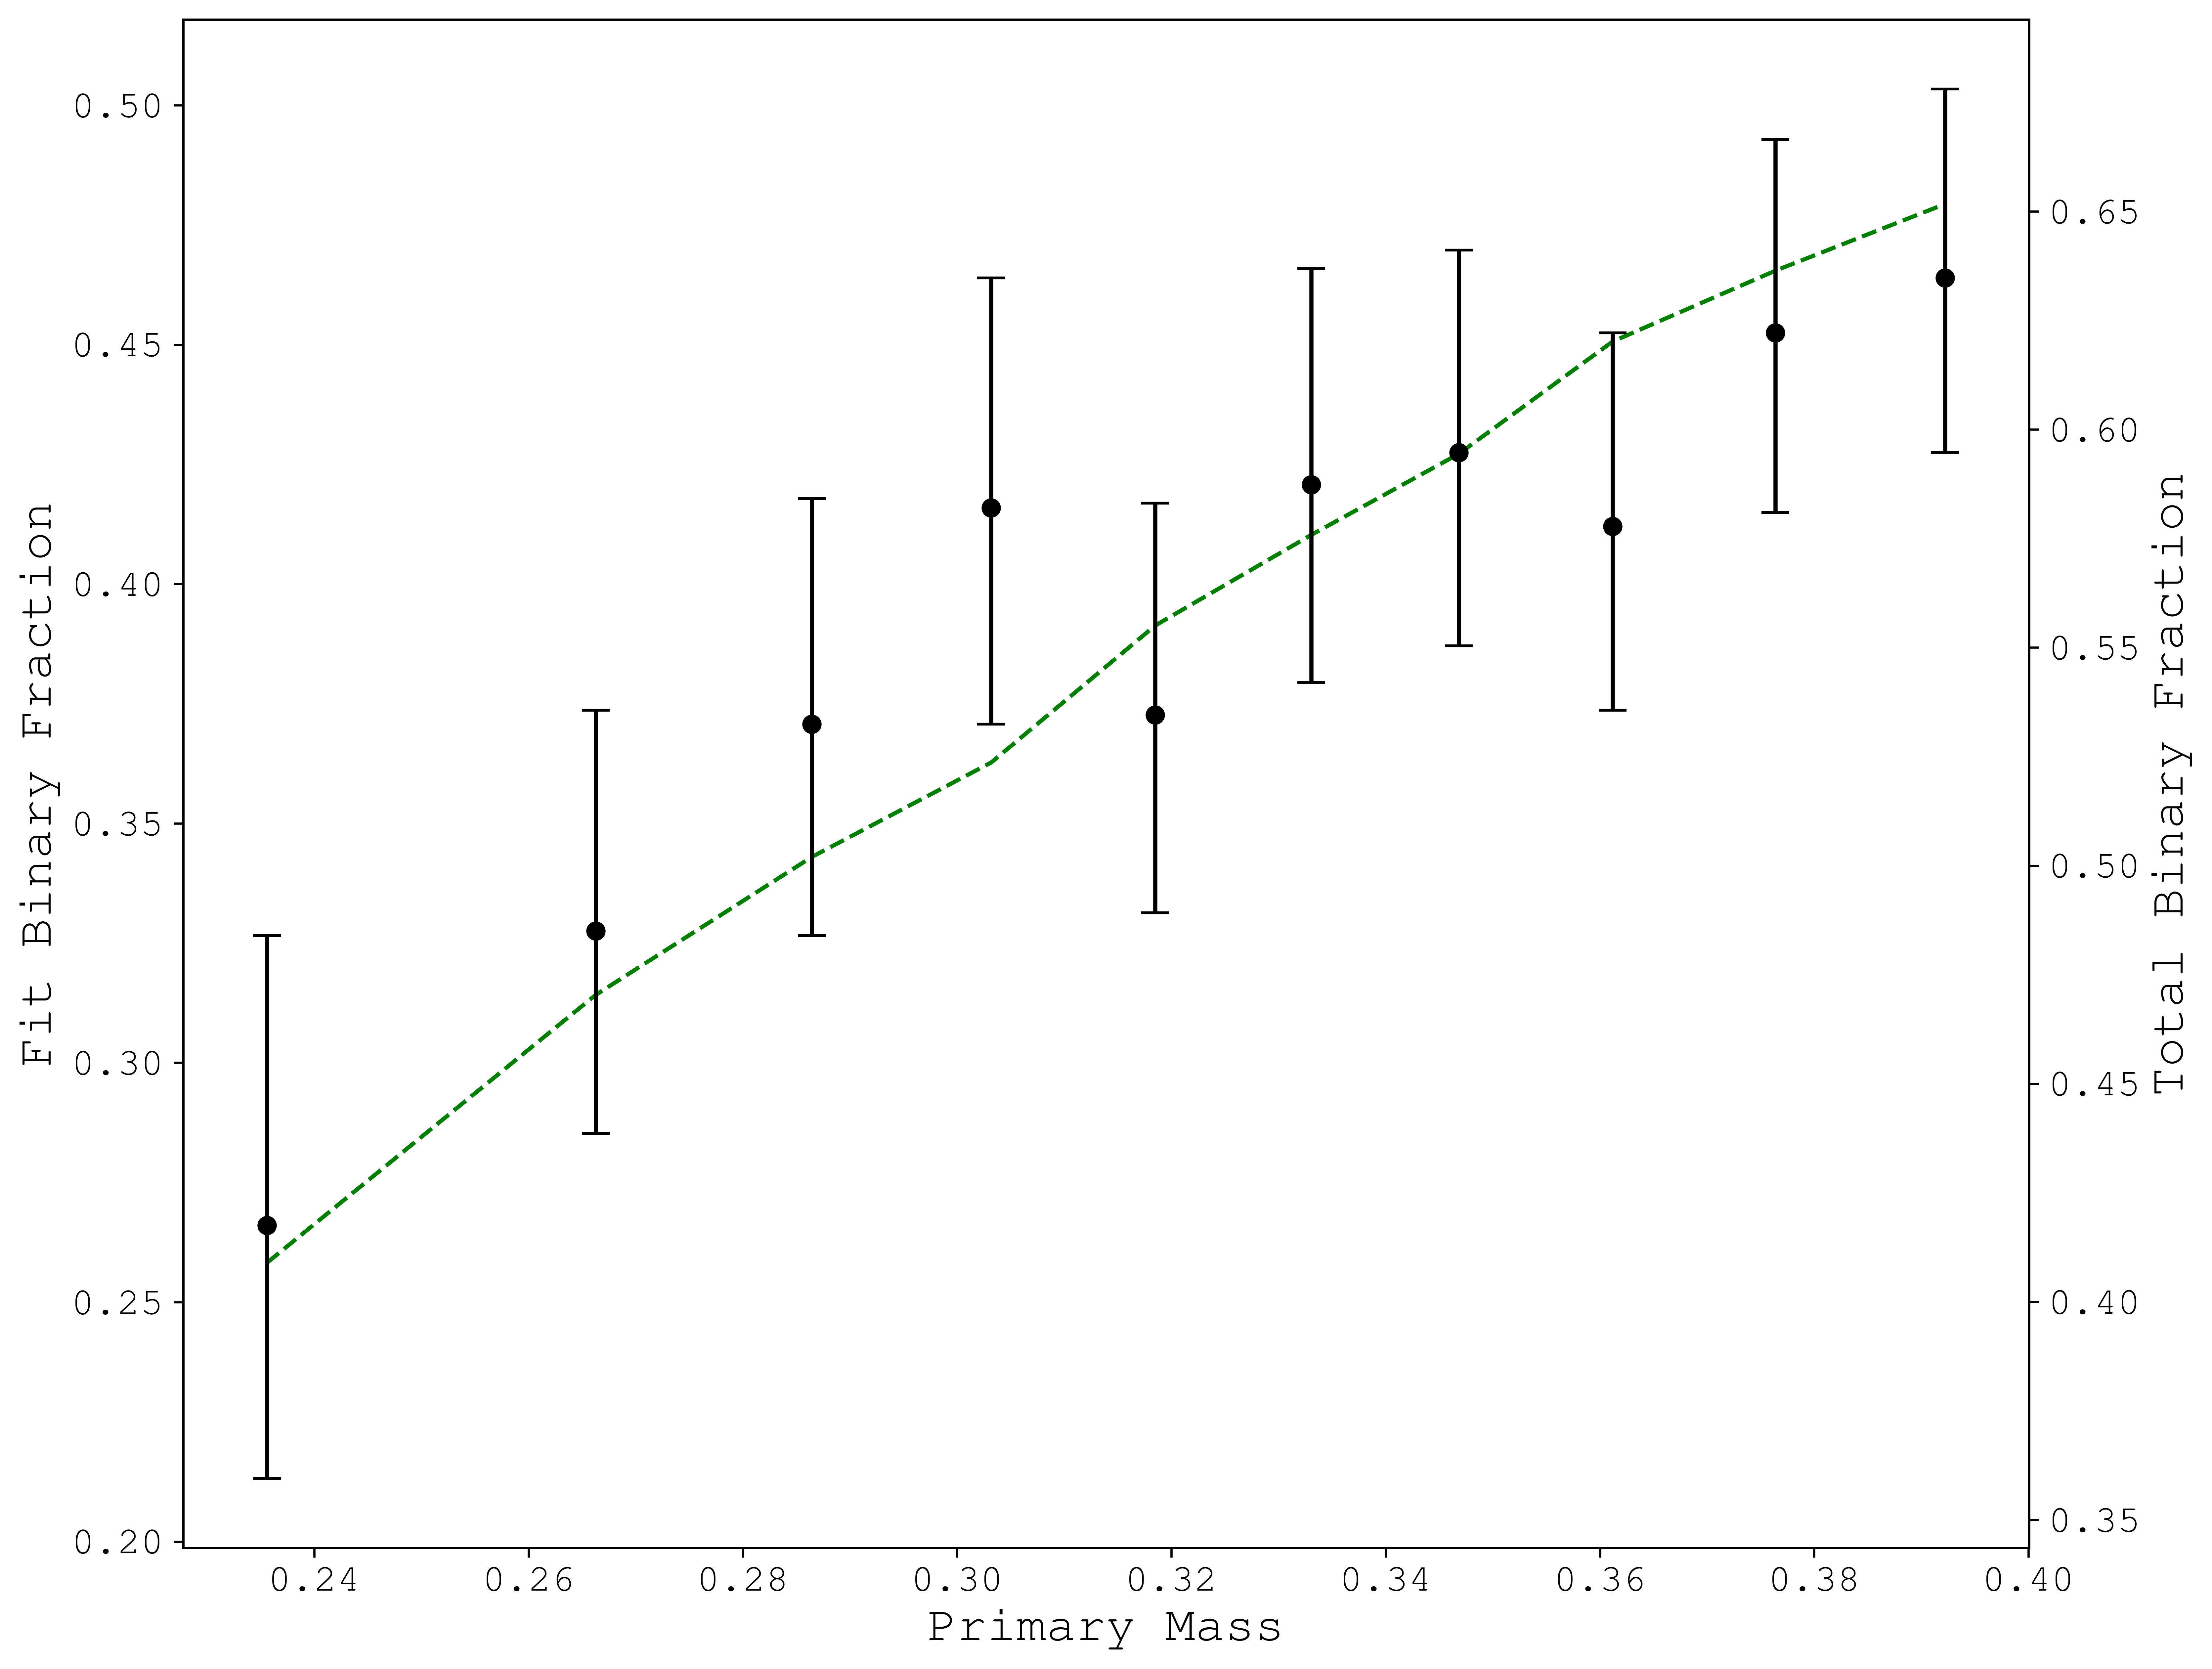

In [7]:
a = Sampler.area_in_range_powerlaw((0.05,1), 0)/Sampler.area_in_range_powerlaw((0.05,0.5), 0)
plt.errorbar(mass_lims, synth_results[:,0], yerr=(synth_results[:,2], synth_results[:,1]), fmt='none', capsize=5, ecolor='k', zorder=1);
plt.scatter(mass_lims, synth_results[:,0], marker='o', c="k", zorder=2);
plt.plot(mass_lims, refrates, c="green", linestyle="--", zorder=0);
#plt.axhline(y=0.3, c="green", linestyle="--");
plt.xlabel("Primary Mass");
plt.ylabel("Fit Binary Fraction");
ymin, ymax = plt.ylim()
ax = plt.twinx();
ax.set_ylim(Sampler.convert_binarity(ymin, a), Sampler.convert_binarity(ymax, a));
ax.set_ylabel("Total Binary Fraction");